
MNIST ("Modified National Institute of Standards and Technology") is computer vision dataset released in 1999. It contains data of handwritten images and it is the "de facto" benchmark for classification algorithms. The goal is to correctly identify digits from a dataset of tens of thousands of handwritten images.



![](http://corochann.com/wp-content/uploads/2017/02/mnist_plot.png)

# The data

The data description can be found at [Kaggle](https://www.kaggle.com/c/digit-recognizer/data):

> The data files train.csv and test.csv contain gray-scale images of hand-drawn digits, from zero through nine.

> **Each image is 28 pixels in height and 28 pixels in width**, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. **This pixel-value is an integer between 0 and 255, inclusive**.

> The training data set, (train.csv), has 785 columns. The first column, called "label", is the digit that was drawn by the user. The rest of the columns contain the pixel-values of the associated image.

> Each pixel column in the training set has a name like pixelx, where x is an integer between 0 and 783, inclusive. To locate this pixel on the image, suppose that we have decomposed x as x = i * 28 + j, where i and j are integers between 0 and 27, inclusive. Then pixelx is located on row i and column j of a 28 x 28 matrix, (indexing by zero).

In [1]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data.dataloader as dataloader
import torch.optim as optim

from torch.utils.data import TensorDataset
from torch.autograd import Variable
from torchvision import transforms
from torchvision.datasets import MNIST

from sklearn import metrics

%matplotlib inline

In [3]:
rcParams['figure.figsize'] = 14, 8

sns.set(style='whitegrid', palette='muted', font_scale=2)

In [4]:
train = MNIST('./data', train=True, download=True, transform=transforms.Compose([
    transforms.ToTensor(), # ToTensor does min-max normalization. 
]), )

test = MNIST('./data', train=False, download=True, transform=transforms.Compose([
    transforms.ToTensor(), # ToTensor does min-max normalization. 
]), )


dataloader_args = dict(shuffle=True, batch_size=64,num_workers=1)
train_loader = dataloader.DataLoader(train, **dataloader_args)
test_loader = dataloader.DataLoader(test, **dataloader_args)

# Exploration

In [5]:
train.train_data.size()

torch.Size([60000, 28, 28])

In [6]:
test.test_data.size()

torch.Size([10000, 28, 28])

In [7]:
train.train_data[0] # .numpy().flatten()



Columns 0 to 12 
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     3
    0     0     0     0     0     0     0     0    30    36    94   154   170
    0     0     0     0     0     0     0    49   238   253   253   253   253
    0     0     0     0     0     0     0    18   219   253   253   253   253
    0     0     0     0     0     0     0     0    80   156   107   253   253
    0     0     0     0     0     0     0     0     0    14     1   154   253
    0     0     0     0     0     0     0     0     0     0     0   139   253
    0     0     0     0     0     0     0    

In [8]:
def show_digit(digit):
    plt.imshow(digit.view(28, 28).numpy(), cmap='gray')

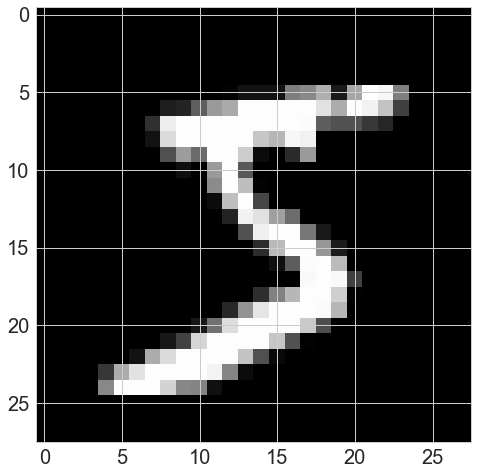

In [9]:
show_digit(train.train_data[0])

In [10]:
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - Transformed Shape:', train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - Transformed Shape: torch.Size([28, 60000, 28])
 - min: 0.0
 - max: 1.0
 - mean: 0.13066047740240005
 - std: 0.3081078089011192
 - var: 0.0949304219058486


# Building the model

In [11]:
class Model(nn.Module):

    def __init__(self):
        super(Model, self).__init__()
        self.l1 = nn.Linear(784, 520)
        self.l2 = nn.Linear(520, 320)
        self.l3 = nn.Linear(320, 240)
        self.l4 = nn.Linear(240, 120)
        self.l5 = nn.Linear(120, 10)

    def forward(self, x):
        x = x.view(-1, 784)  # Flatten the data (n, 1, 28, 28)-> (n, 784)
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = F.relu(self.l3(x))
        x = F.relu(self.l4(x))
        return self.l5(x)

# Training

In [12]:
model = Model()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [13]:
train_loss = []
test_loss = []


for epoch in range(15):
    model.train()
    e_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        
        data, target = Variable(data), Variable(target)
        
        optimizer.zero_grad()

        y_pred = model(data) 

        loss = criterion(y_pred, target)
        e_train_loss.append(loss.data[0])
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        
    mean_train_loss = np.mean(e_train_loss)
    train_loss.append(mean_train_loss)
        
        
        
    model.eval()
    e_test_loss = []
    correct = 0
    for data, target in test_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        
        loss = criterion(output, target).data[0]
        e_test_loss.append(loss)
        
        # get the index of the max
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
    
    mean_test_loss = np.mean(e_test_loss)
    test_loss.append(mean_test_loss)
    
    print(f"""
    ######### Epoch {epoch + 1} #########\n
    average train loss: {mean_train_loss}
    average test loss: {mean_test_loss}
    test accuracy: {correct}/{len(test_loader.dataset)} {100. * correct / len(test_loader.dataset)}%
""")


    ######### Epoch 1 #########

    average train loss: 0.269259071835418
    average test loss: 0.1247172473579835
    test accuracy: 9636/10000 96.36%


    ######### Epoch 2 #########

    average train loss: 0.09922434533261128
    average test loss: 0.09329366170842747
    test accuracy: 9712/10000 97.12%


    ######### Epoch 3 #########

    average train loss: 0.07082340353907499
    average test loss: 0.08685463448322028
    test accuracy: 9749/10000 97.49%


    ######### Epoch 4 #########

    average train loss: 0.05457331964468483
    average test loss: 0.07656577506115969
    test accuracy: 9785/10000 97.85%


    ######### Epoch 5 #########

    average train loss: 0.04485639721452535
    average test loss: 0.08300408095219261
    test accuracy: 9775/10000 97.75%


    ######### Epoch 6 #########

    average train loss: 0.03684792957101851
    average test loss: 0.08302563657816558
    test accuracy: 9779/10000 97.79%


    ######### Epoch 7 #########

    average tra

# Evaluation

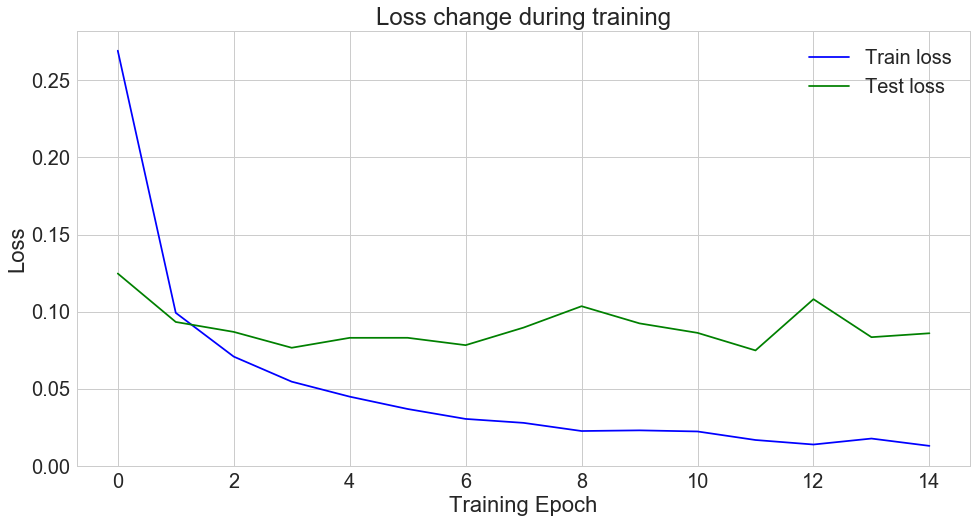

In [14]:
plt.figure(figsize=(16, 8))

plt.plot(train_loss, "b", label="Train loss")

plt.plot(test_loss, "g", label="Test loss")

plt.title("Loss change during training")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)

plt.show();

## Extracting predictions

In [17]:
model.eval()

ys = []
y_hats = []

for data, target in test_loader:
    data= Variable(data, volatile=True)
    output = model(data)

    pred = output.data.max(1, keepdim=True)[1].numpy().flatten()
    
    y_hats.extend(pred)
    ys.extend(target)

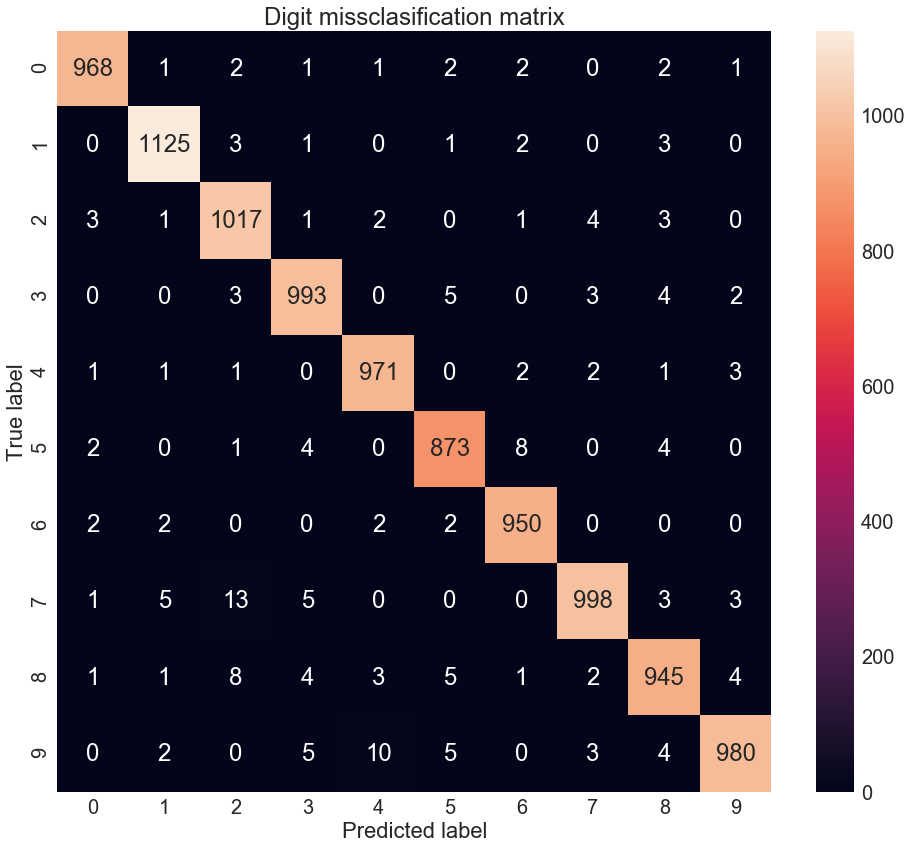

In [18]:
confusion_matrix = metrics.confusion_matrix(ys, y_hats)

plt.figure(figsize=(16, 14))
sns.heatmap(confusion_matrix, annot=True, fmt="d")
plt.title("Digit missclasification matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show();

## Classify single digit

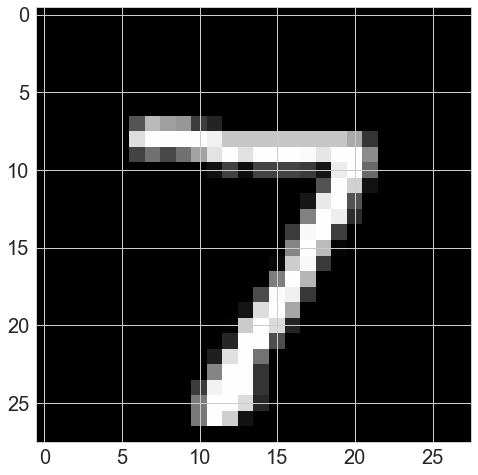

In [19]:
show_digit(test.test_data[0])

In [23]:
test.test_labels[0]

7

In [29]:
model.eval()

data= Variable(test.test_data[0].float(), volatile=True)
output = model(data)

pred = output.data.max(1, keepdim=True)[1]
pred


 7
[torch.LongTensor of size 1x1]